In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline


In [15]:
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv"
all_df = pd.read_csv(url)

columns = [
    'engine_displacement',
    'horsepower',
    'vehicle_weight',
    'model_year',
    'fuel_efficiency_mpg'
]
df = all_df[columns]
print(len(df))
df['fuel_efficiency_mpg'].describe()

9704


count    9704.000000
mean       14.985243
std         2.556468
min         6.200971
25%        13.267459
50%        15.006037
75%        16.707965
max        25.967222
Name: fuel_efficiency_mpg, dtype: float64

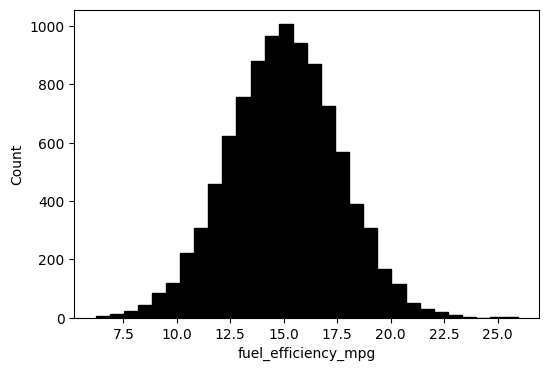

In [16]:
plt.figure(figsize=(6,4))
sns.histplot(df.fuel_efficiency_mpg, bins=30, color="black", alpha=1)
plt.ylabal=("Frequency")
plt.xlabel=("Fuel Efficiency (mpg)")
plt.title=("Distribution of Fuel Efficiency (mpg)")
plt.show()

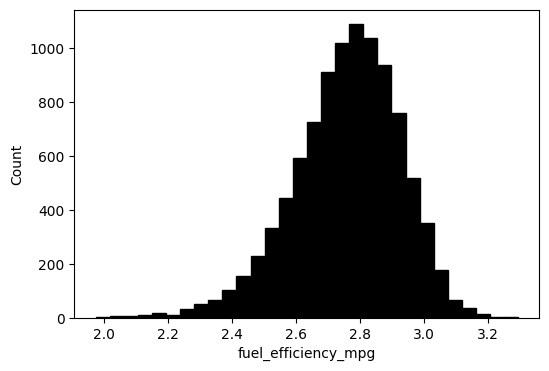

In [17]:
fuel_efficiency = log_price = np.log1p(df.fuel_efficiency_mpg)

plt.figure(figsize=(6,4))
sns.histplot(fuel_efficiency, bins=30, color="black", alpha=1)
plt.ylabal=('Frequency')
plt.xlabel=('Log(Fuel Efficiency + 1)')
plt.title=('Distribution of Fuel Efficiency (mpg)')
plt.show()

In [18]:
# Q1: Which column has missing values?
print(df.isnull().sum())

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64


In [19]:
# Q2 What's the median (50% percentile) for variable 'horsepower'
median_hp = df['horsepower'].median()
print(median_hp)

149.0


In [20]:
# Preparation and split the dataset (train/val/test sets, 60%/20%/20%)
np.random.seed(42)
n = len(df)
n_val = int(0.2*n)
n_test = int(0.2*n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

# y_train_orig = df_train.fuel_efficiency_mpg.values
# y_val_orig = df_val.fuel_efficiency_mpg.values
# y_test_orig = df_test.fuel_efficiency_mpg.values

# y_train = np.log1p(df_train.fuel_efficiency_mpg.values)
# y_val = np.log1p(df_val.fuel_efficiency_mpg.values)
# y_test = np.log1p(df_test.fuel_efficiency_mpg.values)

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

In [21]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]
    
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

base = [
    'engine_displacement',
    'horsepower',
    'vehicle_weight',
    'model_year'
]

In [22]:
# --------------------------
#  Filling with zero and fitting LR 
# ---------------------------

df_train_zero = df_train.copy()
df_val_zero = df_val.copy()

df_train_zero['horsepower'] = df_train_zero['horsepower'].fillna(0)
df_val_zero['horsepower'] = df_val_zero['horsepower'].fillna(0)

X_train_zero = df_train_zero.values
w_0, w = train_linear_regression(X_train_zero, y_train)

X_val_zero = df_val_zero.values
y_pred = w_0 + X_val_zero.dot(w)
rmse_val_zero = rmse(y_val, y_pred)
print('Validation | RMSE (fill 0):', round(rmse_val_zero, 2))

Validation | RMSE (fill 0): 0.52


In [23]:

# --------------------------
#  Filling with mean and fitting LR 
# ---------------------------
mean_hp = df_train['horsepower'].mean()

df_train_mean = df_train.copy()
df_val_mean = df_val.copy()

df_train_mean['horsepower'] = df_train_mean['horsepower'].fillna(mean_hp)
df_val_mean['horsepower'] = df_val_mean['horsepower'].fillna(mean_hp)

X_train_mean = df_train_mean.values
w_0, w = train_linear_regression(X_train_mean, y_train)

X_val_mean = df_val_mean.values
y_pred = w_0 + X_val_mean.dot(w)
rmse_val_mean = rmse(y_val, y_pred)
print('Validation | RMSE (fill mean):', round(rmse_val_mean, 2))

Validation | RMSE (fill mean): 0.46


In [24]:
# Q4
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

def prepare_X(df):
    df = df.copy()
    features = base.copy()
    # print(df['model_year'].head(10))
    # df['model_year'] = 2025 - df.model_year
    # print(df['model_year'].value_counts())
    df_num = df[features]
    df_num = df_num.fillna(0)
    return df_num.values

X_train = prepare_X(df_train)

X_val =prepare_X(df_val)

for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    print('%6s' %r,  round(rmse(y_val, y_pred), 3))

     0 0.517
  0.01 0.517
   0.1 0.519
     1 0.522
     5 0.523
    10 0.523
   100 0.523


In [25]:
# Q5
def prepare_data(df, seed=42):
    np.random.seed(seed)
    n = len(df)
    idx = np.arange(n)
    np.random.shuffle(idx)
    df = df.iloc[idx]
    return df

seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
calculated_rsme = []

for seed in seeds:
    df_copy = df.copy()
    df_shuffled = prepare_data(df_copy,seed)
    
    n = len(df)
    n_val = int(0.2*n)
    n_test = int(0.2*n)
    n_train = n - (n_val + n_test)
    
    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()

    y_train = df_train.fuel_efficiency_mpg.values
    y_val = df_val.fuel_efficiency_mpg.values
    y_test = df_test.fuel_efficiency_mpg.values
    

    del df_train['fuel_efficiency_mpg']
    del df_val['fuel_efficiency_mpg']
    del df_test['fuel_efficiency_mpg']

    df_train_zero = df_train.copy()
    df_val_zero = df_val.copy()
    
    df_train_zero['horsepower'] = df_train_zero['horsepower'].fillna(0)
    df_val_zero['horsepower'] = df_val_zero['horsepower'].fillna(0)
    
    X_train_zero = df_train_zero.values
    w_0, w = train_linear_regression(X_train_zero, y_train)
    
    X_val_zero = df_val_zero.values
    y_pred = w_0 + X_val_zero.dot(w)
    rmse_val_zero = rmse(y_val, y_pred)
    # print(f'seed={seed} | r={r}  | RMSE: {rmse_val_zero}')
    calculated_rsme.append(rmse_val_zero)

print(np.std(calculated_rsme))
print(f'std = {round(np.std(calculated_rsme),3)}')
    

0.006989446426433706
std = 0.007


In [26]:
# Q6
df_copy = df.copy()
df_shuffled = prepare_data(df_copy,9)

n = len(df)
n_val = int(0.2*n)
n_test = int(0.2*n)
n_train = n - (n_val + n_test)

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()
df_combined_train = pd.concat([df_train,df_val])

y_combined_train = df_combined_train.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

del df_combined_train['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

X_train = prepare_X(df_combined_train)
X_test =prepare_X(df_test)

r = 0.001
w_0, w = train_linear_regression_reg(X_train, y_combined_train, r=r)
y_pred = w_0 + X_test.dot(w)
print('%6s' %r,  round(rmse(y_test, y_pred), 3))

 0.001 0.516
